In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
from irt import NCFModel, NCF
import torch
import os
device ='cuda:0'
train_data_path = "../data/flickr/processed/train/"
test_data_path = "../data/flickr/processed/test/"
irt_models_path = "../data/flickr/evaluation/irt_models/"
ncf_model_path = "../data/flickr/evaluation/classifier/"
ncf_model_file = "ncf_usrthrs_0.pkl"

In [3]:
ncf = NCF()
ncf.load(f"{ncf_model_path}/{ncf_model_file}")

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
data_test = pd.read_csv(test_data_path+"test_usrthrs_0.csv")
E_test = torch.load(test_data_path+"test_ie_usrthrs_0.pt", weights_only=True)
U_test = torch.tensor(data_test.worker_id)

In [6]:
ncf.score(U_test, E_test.to(torch.float32))

{0: {'avg': 0.11823351681232452, 'std_error': 0.04696689918637276},
 1: {'avg': 0.5654741525650024, 'std_error': 0.07884438335895538},
 2: {'avg': 0.25403016805648804, 'std_error': 0.08045752346515656},
 3: {'avg': 0.4500581622123718, 'std_error': 0.07812010496854782},
 4: {'avg': 0.3693416118621826, 'std_error': 0.09959562867879868},
 5: {'avg': 0.4001348614692688, 'std_error': 0.08583883941173553},
 6: {'avg': 0.4553627371788025, 'std_error': 0.09848164021968842},
 7: {'avg': 0.5372921824455261, 'std_error': 0.09185779839754105},
 8: {'avg': 0.5027067065238953, 'std_error': 0.07565217465162277},
 9: {'avg': 0.15658167004585266, 'std_error': 0.05623673275113106},
 10: {'avg': 0.3388136923313141, 'std_error': 0.08999205380678177},
 11: {'avg': 0.21562746167182922, 'std_error': 0.06562501192092896},
 12: {'avg': 0.45726752281188965, 'std_error': 0.10745871812105179},
 13: {'avg': 0.1430082768201828, 'std_error': 0.054391488432884216},
 14: {'avg': 0.5140447616577148, 'std_error': 0.1030

In [7]:
pipe_cfg = 5.0
embcfg = 9.0
seed = 42

prefix = f"embcfg_{embcfg}_pipecfg_{pipe_cfg}_seed_{seed}"
data_dir = f"../data/flickr/evaluation/diffusion_priors/models/samples/{prefix}"
user_idx = range(210)

prior_embeddings, posterior_embeddings = [], []
for user_id in user_idx:
    user_data = torch.load(f"{data_dir}/{prefix}_userid_{user_id}.data", weights_only=False)
    prior_embeddings.append(user_data["prior_embeddings"])
    posterior_embeddings.append(user_data["posterior_embeddings"])

prior_embeddings = torch.cat(prior_embeddings)
posterior_embeddings = torch.cat(posterior_embeddings)

u_ids = torch.tensor([i//100 for i in range(prior_embeddings.shape[0])])


In [8]:
n_perms = 1000
perm_prior_tensor = torch.zeros((n_perms, ncf.model.num_users))
for i in range(n_perms):
    u_perm = u_ids[torch.randperm(u_ids.shape[0])]
    prior_scores = ncf.score(u_perm, prior_embeddings.to(torch.float32))
    perm_avgs = torch.tensor([prior_scores[j]["avg"] for j in prior_scores.keys()])
    perm_prior_tensor[i] = perm_avgs


n_perms = 1000
perm_posterior_tensor = torch.zeros((n_perms, ncf.model.num_users))
for i in range(n_perms):
    u_perm = u_ids[torch.randperm(u_ids.shape[0])]
    posterior_scores = ncf.score(u_perm, posterior_embeddings.to(torch.float32))
    perm_avgs = torch.tensor([posterior_scores[j]["avg"] for j in posterior_scores.keys()])
    perm_posterior_tensor[i] = perm_avgs


real_prior_scores = ncf.score(u_ids, prior_embeddings.to(torch.float32))
real_prior_avgs = torch.tensor([real_prior_scores[i]["avg"] for i in real_prior_scores.keys()])
real_posterior_scores = ncf.score(u_ids, posterior_embeddings.to(torch.float32))
real_posterior_avgs = torch.tensor([real_posterior_scores[i]["avg"] for i in real_posterior_scores.keys()])


perm_prior_means = perm_prior_tensor.mean(dim=1)
perm_prior_medians = perm_prior_tensor.median(dim=1).values
perm_posterior_means = perm_posterior_tensor.mean(dim=1)
perm_posterior_medians = perm_posterior_tensor.median(dim=1).values




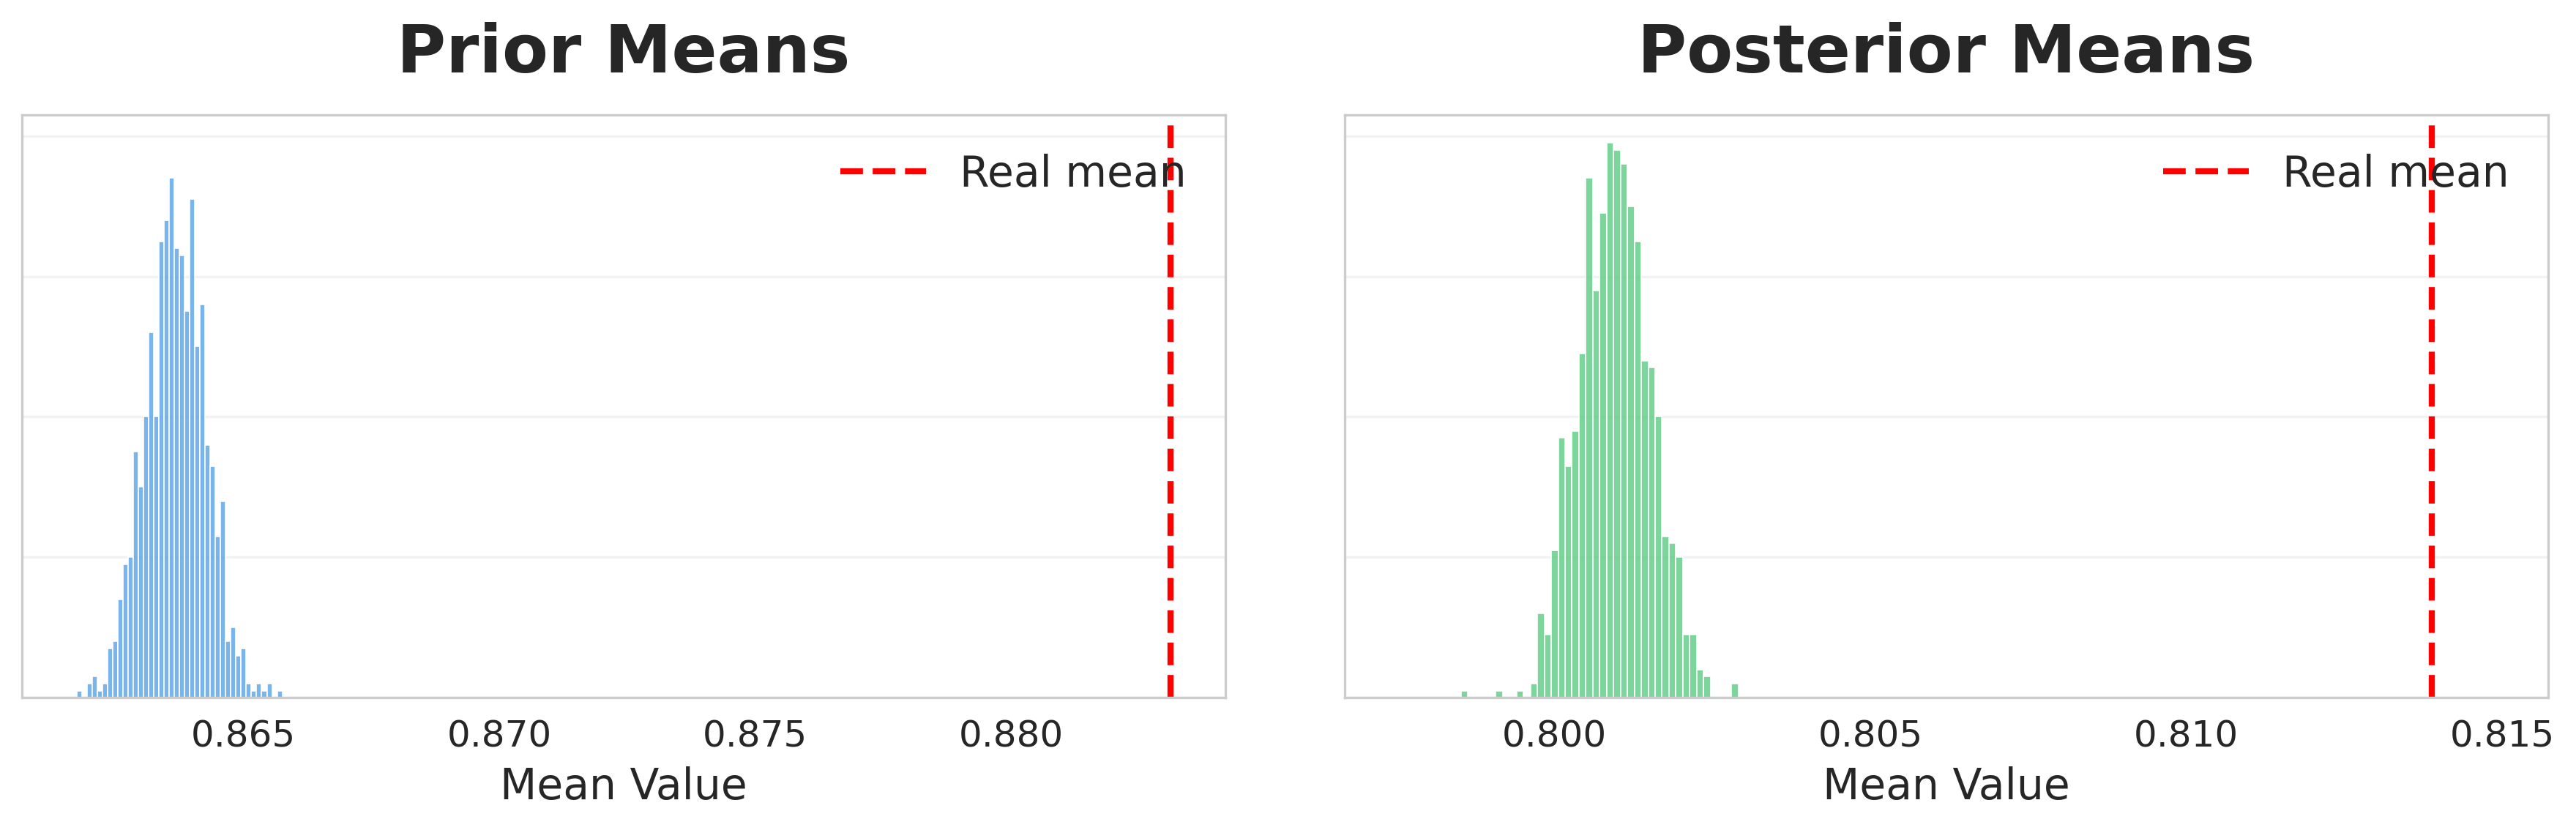

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

# ---- CVPR-style aesthetics (keep yours) ----
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 22,      # bigger titles like in your screenshot
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.transparent": True,
})
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# ---------- Prior ----------
sns.histplot(perm_prior_means, bins=40, kde=False, color="#4C9BE8",
             edgecolor="white", lw=0.4, ax=axes[0])
axes[0].axvline(real_prior_avgs.mean(), color="red", ls="--", lw=2, label="Real mean")
axes[0].set_title("Prior Means", weight="bold", pad=14)
axes[0].set_xlabel("Mean Value")
axes[0].set_ylabel("")
axes[0].tick_params(axis="y", left=False, labelleft=False)
axes[0].legend(frameon=False, loc="upper right")
# Make ticks readable
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].xaxis.set_major_formatter(FormatStrFormatter("%.3f"))

# ---------- Posterior ----------
sns.histplot(perm_posterior_means, bins=40, kde=False, color="#50C878",
             edgecolor="white", lw=0.4, ax=axes[1])
axes[1].axvline(real_posterior_avgs.mean(), color="red", ls="--", lw=2, label="Real mean")
axes[1].set_title("Posterior Means", weight="bold", pad=14)
axes[1].set_xlabel("Mean Value")
axes[1].set_ylabel("")
axes[1].tick_params(axis="y", left=False, labelleft=False)
axes[1].legend(frameon=False, loc="upper right")

# Fix the cramped ticks: fewer ticks + 3 decimals + a bit of padding
lo = float(min(perm_posterior_means.min(), real_posterior_avgs.mean()))
hi = float(max(perm_posterior_means.max(), real_posterior_avgs.mean()))
pad = max(1e-4, 0.12 * (hi - lo))  # gentle padding if the range is tiny
axes[1].set_xlim(lo - pad, hi + pad)
axes[1].xaxis.set_major_locator(MaxNLocator(nbins=4))
axes[1].xaxis.set_major_formatter(FormatStrFormatter("%.3f"))

# Optional: horizontal grid only (cleaner)
for ax in axes:
    ax.grid(axis="x", visible=False)
    ax.grid(axis="y", alpha=0.25)

plt.tight_layout(w_pad=2.8)
plt.savefig("prior_posterior_means_comparison.pdf", bbox_inches="tight")
plt.savefig("prior_posterior_means_comparison.png", bbox_inches="tight", dpi=600)
plt.show()


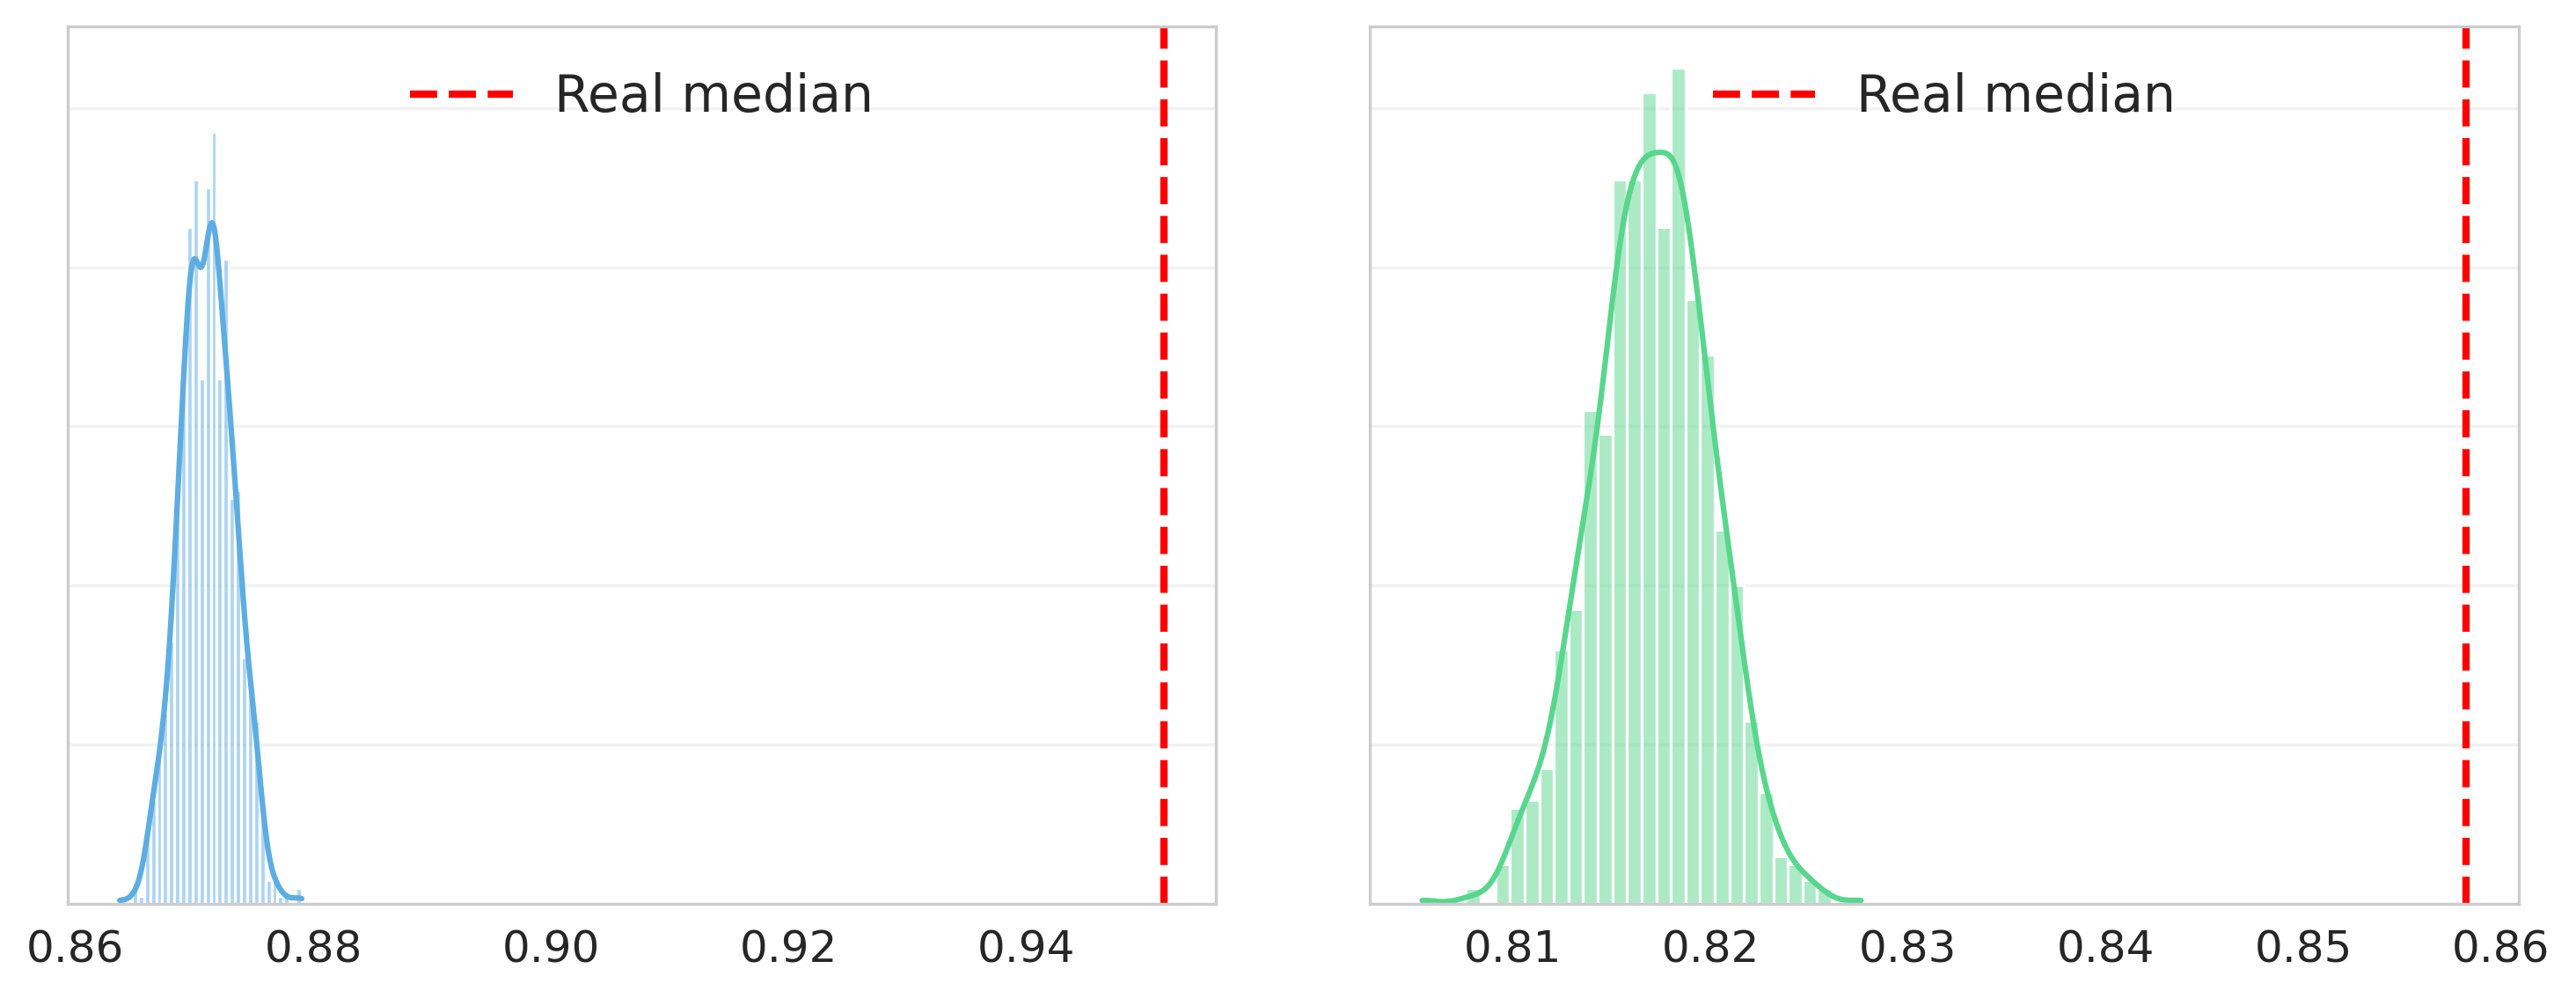

In [24]:
# ---- Create side-by-side figure ----
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Prior means
sns.histplot(perm_prior_medians, bins=30, stat="probability", kde=True, color="#5DADE2", ax=axes[0])
axes[0].axvline(real_prior_avgs.median(), color="red", linestyle="--", linewidth=2, label="Real median")
#axes[0].set_title("Prior Medians", weight="bold")
#axes[0].set_xlabel("Median value")
axes[0].set_ylabel("")
axes[0].tick_params(axis='y', which='both', left=False, labelleft=False)  # remove y-ticks
axes[0].legend(frameon=False, loc="upper center")

# Posterior means
sns.histplot(perm_posterior_medians, bins=30, stat="probability", kde=True, color="#58D68D", ax=axes[1])
axes[1].axvline(real_posterior_avgs.median(), color="red", linestyle="--", linewidth=2, label="Real median")
#axes[1].set_title("Posterior Medians", weight="bold")
#axes[1].set_xlabel("Median value")
axes[1].set_ylabel("")
axes[1].tick_params(axis='y', which='both', left=False, labelleft=False)  # remove y-ticks
axes[1].legend(frameon=False)


for ax in axes:
    ax.grid(axis="x", visible=False)
    ax.grid(axis="y", alpha=0.25)

# ---- Layout and export ----
plt.tight_layout(w_pad=3)
plt.savefig("prior_posterior_medians_comparison.pdf", bbox_inches="tight", dpi=600)
plt.show()

In [8]:
gen_data = torch.load("../data/flickr/evaluation/diffusion_priors/samples/front_cover/front_cover_samples_newzip.pt", weights_only=False)

In [32]:
ncf.model.num_users

210

In [51]:
prior_embeddings = torch.cat([gen_data[i]["prior_embeddings"] for i in range(len(gen_data))], dim=0)
posterior_embeddings = torch.cat([gen_data[i]["posterior_embeddings"] for i in range(len(gen_data))], dim=0)

In [14]:
# I am assuming each user has 10 embeddings, which they do for the front cover samples
u_ids = torch.tensor([i//10 for i in range(prior_embeddings.shape[0])])

In [ ]:
u_ids.shape


torch.Size([2100])

In [57]:
n_perms = 1000
perm_prior_tensor = torch.zeros((n_perms, ncf.model.num_users))
for i in range(n_perms):
    u_perm = u_ids[torch.randperm(u_ids.shape[0])]
    prior_scores = ncf.score(u_perm, prior_embeddings.to(torch.float32))
    perm_avgs = torch.tensor([prior_scores[j]["avg"] for j in prior_scores.keys()])
    perm_prior_tensor[i] = perm_avgs


In [58]:
n_perms = 1000
perm_posterior_tensor = torch.zeros((n_perms, ncf.model.num_users))
for i in range(n_perms):
    u_perm = u_ids[torch.randperm(u_ids.shape[0])]
    posterior_scores = ncf.score(u_perm, posterior_embeddings.to(torch.float32))
    perm_avgs = torch.tensor([posterior_scores[j]["avg"] for j in posterior_scores.keys()])
    perm_posterior_tensor[i] = perm_avgs

In [52]:
real_prior_scores = ncf.score(u_ids, prior_embeddings.to(torch.float32))
real_prior_avgs = torch.tensor([real_prior_scores[i]["avg"] for i in real_prior_scores.keys()])
real_posterior_scores = ncf.score(u_ids, posterior_embeddings.to(torch.float32))
real_posterior_avgs = torch.tensor([real_posterior_scores[i]["avg"] for i in real_posterior_scores.keys()])

In [62]:
perm_prior_means = perm_prior_tensor.mean(dim=1)
perm_prior_medians = perm_prior_tensor.median(dim=1).values
perm_posterior_means = perm_posterior_tensor.mean(dim=1)
perm_posterior_medians = perm_posterior_tensor.median(dim=1).values

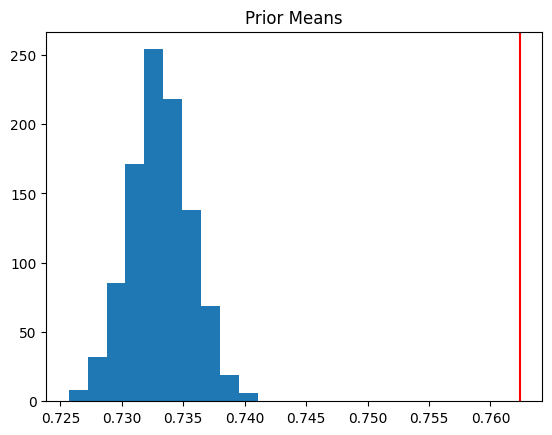

In [67]:
plt.hist(perm_prior_means)
plt.axvline(real_prior_avgs.mean(), color='red')
plt.title("Prior Means")
plt.show()

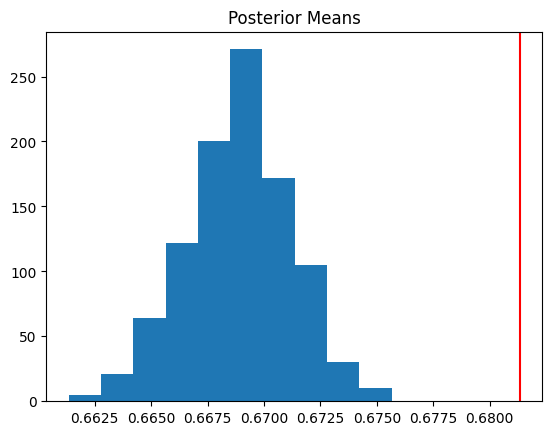

In [66]:
plt.hist(perm_posterior_means)
plt.axvline(real_posterior_avgs.mean(), color='red')
plt.title("Posterior Means")
plt.show()

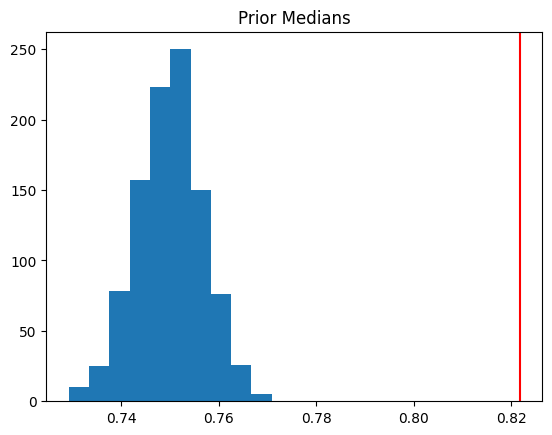

In [68]:
plt.hist(perm_prior_medians)
plt.axvline(real_prior_avgs.median(), color='red')
plt.title("Prior Medians")
plt.show()

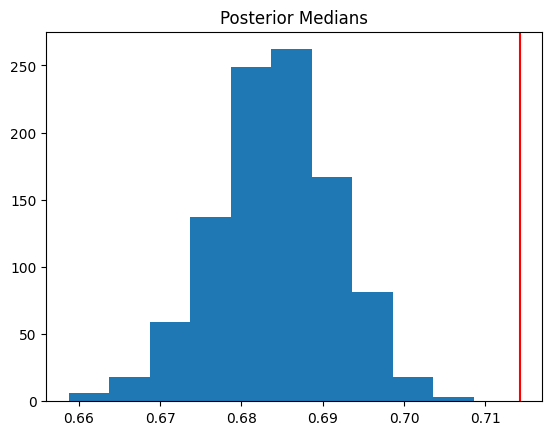

In [69]:
plt.hist(perm_posterior_medians)
plt.axvline(real_posterior_avgs.median(), color='red')
plt.title("Posterior Medians")
plt.show()

In [5]:
PR_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/test"

scores = dict.fromkeys(os.listdir(PR_DIR))

for candidate in os.listdir(PR_DIR):
    if "exp2" not in candidate:
        continue
    print(candidate)
    candidate_dir = os.path.join(PR_DIR, candidate)
    user_scores = dict.fromkeys(os.listdir(candidate_dir))
    for user in os.listdir(candidate_dir):
        
        images_dir = os.path.join(candidate_dir, user, "images")
        sdxl_ipadapter_embs = []
        with torch.no_grad():
            for path in os.listdir(images_dir):
                #path = "../data/raw/FLICKR-AES-001/40K/" + unq_img_path
                impath = os.path.join(images_dir, path)
                pil_image = load_image(impath)
                image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
                sdxl_ipadapter_embs.append(image_emb.cpu())
            sdxl_ipadapter_embs_tensor = torch.stack(sdxl_ipadapter_embs)
            torch.save(sdxl_ipadapter_embs_tensor, f"{images_dir}/../embeddings/sdxl_embeddings.pth")

SPU_80_GS_10.0__NEG__usrthrs_100_exp2
SPU_80_GS_12.0__NEG__usrthrs_100_exp2
SPU_80_GS_14.0__NEG__usrthrs_100_exp2
SPU_80_GS_16.0__NEG__usrthrs_100_exp2
SPU_80_GS_18.0__NEG__usrthrs_100_exp2
SPU_80_GS_20.0__NEG__usrthrs_100_exp2
SPU_80_GS_8.0__NEG__usrthrs_100_exp2


In [34]:
from diffusion_adapters import StableDiffusionXLPipelineAdapterEmbeddings, StableDiffusionPipelineAdapterEmbeddings
from diffusers.utils import load_image

pipe = StableDiffusionXLPipelineAdapterEmbeddings.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x1024 and 1280x80)